In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import random
import os
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
import lifelines.statistics
import math 

sns.set_theme()
sns.set_context("notebook")
sns.set_palette("colorblind")

# DP - Mechanism Definitions

### Laplacian Noise Time Obfuscation (LNTO)

In [ ]:
def lnto(df, epsilon):
    '''
    Transform event-time DataFrame to differentially private survival analysis format.

    Parameters:
    df: A DataFrame containing 'Status' (1 if event occurred, 0 if censored) 
                       and 'Time' (time until the event or censorship).
    epsilon: Privacy budget for differential privacy.
    
    Returns:
    np.array: Differentially private estimates of survival probabilities.
    '''
    # Sort the dataframe by time
    df_sorted = df.sort_values(by='Time')

    # Get unique times and count events and at risk
    unique_times = df_sorted['Time'].unique()
    result = []
    n = len(df_sorted)  # Total number of subjects initially at risk
    for time in unique_times:
        # Number of events at time t_j
        d_j = df_sorted[(df_sorted['Time'] == time) & (df_sorted['Status'] == 1)].shape[0]
        
        # Append the result for this time
        result.append((time, n, d_j))
        
        # Update the number at risk
        n -= df_sorted[df_sorted['Time'] == time].shape[0]

    # Convert result list to matrix for differential privacy calculations
    D = np.array(result)  # Convert to numpy array for processing
    k = D.shape[0]  # number of timestamps

    # Create the partial matrix M' by adding Laplace noise to r_j and d_j
    M_prime = D[:, 1:3].copy()  # Copy r_j and d_j columns
    for j in range(k):
        M_prime[j, 0] += np.random.laplace(0, 1/epsilon)  # Add noise to r_j
        M_prime[j, 1] += np.random.laplace(0, 1/epsilon)  # Add noise to d_j

    # Initialize the survival probability estimates
    S_prime = np.ones(k)

    # Calculate differentially private estimates of survival probabilities
    for j in range(1, k):
        r_prime = M_prime[j-1, 0] - M_prime[j-1, 1]  # Updated number of subjects at risk
        M_prime[j, 0] = r_prime  # Update r_j' for the next time interval
        if r_prime > 0:  # Avoid division by zero
            S_prime[j] = S_prime[j-1] * (r_prime - M_prime[j, 1]) / r_prime

    return S_prime

### Revised Randomize Response (RRR)

In [2]:
# check if the possible epsilon is negative
def verify_epsilon(p,n):
    epsilon = np.log((n*p+1-p)/(n-1-n*p+p))
    if epsilon <= 0:
        #print('epsilon is negative for such values of p and n')
        return None
    else:
        return epsilon

In [3]:
def revised_coin_toss(category, list_of_cathegories, n, p):
    cathegories = list_of_cathegories
    '''
    category: IPSS-R category, value to be privatized
    list_of_uniques: list of unique cathegories
    n: number of categories (not used in this function, used to compute the epsilon)
    p: coin bias
    '''    
    # compute epsilon
    epsilon = verify_epsilon(p,n)

    # toss a coin H with probability p, T with probability 1-p
    coin = np.random.choice(['H', 'T'], p=[p, 1-p])

    # if coin is H, return the original value
    if coin == 'H':
        return category
    
    # if coin is T, return a random value from the n categories
    else:
        #return a random value from the list of unique values
        return random.choice(list_of_cathegories)


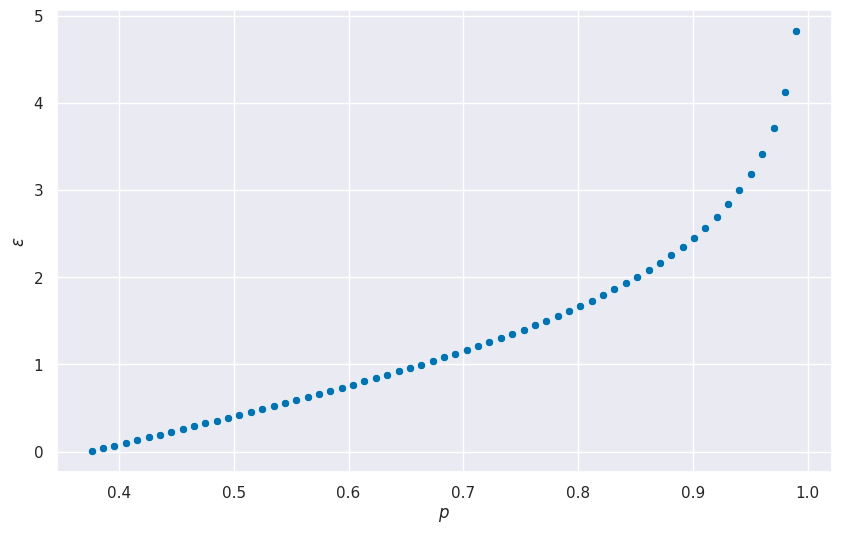

In [4]:
#plot a table of two columns, one is p and the other is the corresponding epsilon
def plot_epsilon(p_values, n):
    epsilons = []
    for p in p_values:
        epsilon = verify_epsilon(p,n)
        epsilons.append(epsilon)
    df = pd.DataFrame({'p': p_values, 'epsilon': epsilons})
    return df

#do an example of the plots
#create a list of p_values to be tested
p_values = np.linspace(0.01, 0.99, 100)
n = 5
df = plot_epsilon(p_values, n)
#plot a distribution of the epsilon
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='p', y='epsilon')
plt.xlabel(r'$p$')
plt.ylabel(r'$\varepsilon$')
#plt.title(r'$\varepsilon$ as a function of $p$ for a fixed number of cathegories $n =$' + f'{n}')
plt.show()



# IPSS-R Dataset

Bernard et al. dataset. URL: https://evidence.nejm.org/doi/full/10.1056/EVIDoa2200008

In [5]:
#define path to data
data_path = "../data/"
bernard = "BernardEtAl/"

#read the data
path_verylow = data_path+bernard+'veryLow.tsv'
df_verylow = pd.read_csv(path_verylow, sep='\t')
path_low = data_path+bernard+'low.tsv'
df_low = pd.read_csv(path_low, sep='\t')
path_int = data_path+bernard+'int.tsv'
df_int = pd.read_csv(path_int, sep='\t')
path_high = data_path+bernard+'high.tsv'
df_high = pd.read_csv(path_high, sep='\t')
path_veryhigh = data_path+bernard+'veryHigh.tsv'
df_veryhigh = pd.read_csv(path_veryhigh, sep='\t')

# Add a column with the risk group to each of the dataframes
df_verylow['Risk Group'] = 'Very Low'
df_low['Risk Group'] = 'Low'
df_int['Risk Group'] = 'Intermediate'
df_high['Risk Group'] = 'High'
df_veryhigh['Risk Group'] = 'Very High'

# Concatenate the dataframes
df = pd.concat([df_verylow, df_low, df_int, df_high, df_veryhigh]).reset_index(drop=True)

df['Status'] = df['Status'].map({'censored': 0, 'deceased': 1})
#eliminate columns
df = df.drop(['Case ID', 'Study ID', 'Survival Rate', 'Number at Risk'], axis=1)
#raname columns
df = df.rename(columns={'Time (months)': 'Time'})

df_ipssr = df.copy()
df

,Status,Time,Risk Group
0,0,0.000000,Very Low
1,0,0.000000,Very Low
2,0,0.000000,Very Low
3,0,0.000000,Very Low
4,0,0.000000,Very Low
...,...,...,...
2995,0,77.786301,Very High
2996,1,79.923288,Very High
2997,0,97.380822,Very High
2998,0,129.665753,Very High


## Group Survival Analysis

### LNTO Simulation

In [6]:
df

,Status,Time,Risk Group
0,0,0.000000,Very Low
1,0,0.000000,Very Low
2,0,0.000000,Very Low
3,0,0.000000,Very Low
4,0,0.000000,Very Low
...,...,...,...
2995,0,77.786301,Very High
2996,1,79.923288,Very High
2997,0,97.380822,Very High
2998,0,129.665753,Very High


### RRR Simulation

In [7]:
#get unique risks groups
risk_groups = df['Risk Group'].unique()
risk_groups

array(['Very Low', 'Low', 'Intermediate', 'High', 'Very High'],
      dtype=object)

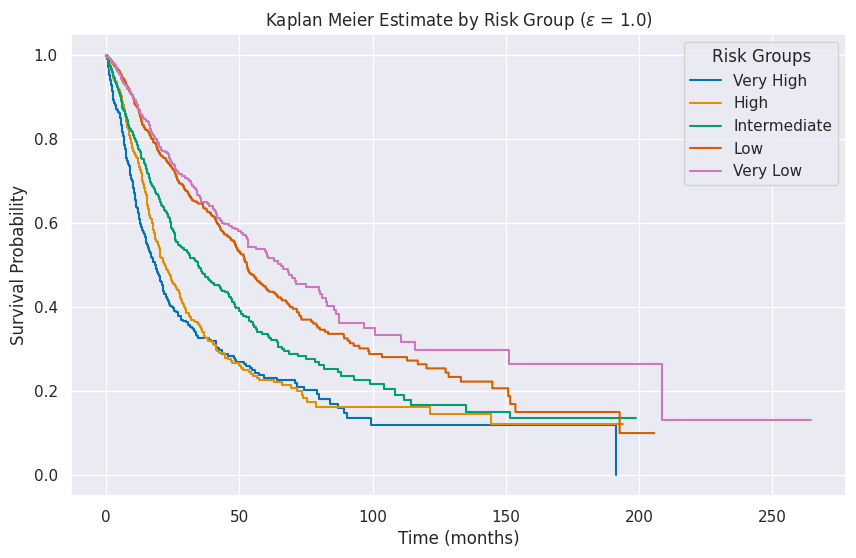

In [8]:
# set the coin bias
#e1 = 1 -> p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#e1 = 2 -> p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#e1 = 3 -> p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
n = len(risk_groups)

p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e1 = verify_epsilon(p, n)
# privatize the IPSS-R category
df['Privatized Risk Group'] = df['Risk Group'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))

groups = df['Privatized Risk Group']
ix_vl = (groups == 'Very Low')
ix_l = (groups == 'Low')
ix_i = (groups == 'Intermediate')
ix_h = (groups == 'High')
ix_vh = (groups == 'Very High')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

plt.title(r'Kaplan Meier Estimate by Risk Group ($\epsilon$ = {})'.format(round(e1, 2)))
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend(title='Risk Groups', loc = 'best')

plt.show()

In [9]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 18.54
     Very High_lower_0.95  Very High_upper_0.95
0.5             15.156164             21.271233
Median survival time: 22.19
     High_lower_0.95  High_upper_0.95
0.5        19.561644        25.841096
Median survival time: 34.62
     Intermediate_lower_0.95  Intermediate_upper_0.95
0.5                27.912329                40.306849
Median survival time: 52.80
     Low_lower_0.95  Low_upper_0.95
0.5       48.986301       57.863014
Median survival time: 65.62
     Very Low_lower_0.95  Very Low_upper_0.95
0.5            53.227397            80.449315


In [10]:
p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e = verify_epsilon(p, n)
times = 100

# Fitting and plotting for each risk group
medians = []
medians_ci = []
dfs = []
for i in range(1, times+1):
    df['Privatized Cancer Group'] = df['Risk Group'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))
    groups = df['Privatized Cancer Group']
    ix_vl = (groups == 'Very Low')
    ix_l = (groups == 'Low')
    ix_i = (groups == 'Intermediate')
    ix_h = (groups == 'High')
    ix_vh = (groups == 'Very High')
    
    km = KaplanMeierFitter()
    for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
        km.fit(df['Time'][ix], df['Status'][ix], label=label)
        medians.append(km.median_survival_time_)
        medians_ci.append(median_survival_times(km.confidence_interval_))
    results_dp = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Privatized Cancer Group'], df['Status'])
    temp = pd.DataFrame(results_dp.summary)
    temp['iteration'] = i
    dfs.append(temp)

In [11]:
results = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Risk Group'], df['Status'])

In [12]:
#concatenate all df in dfs, summing the values of the test statistic and counting the proportion of p-values < 0.05 for each index
df_results = pd.concat(dfs)
df_results = df_results.reset_index()
#group by level_0 and level_1 and sum the values of the test statistic and count the proportion of p-values < 0.05
df_results = df_results.groupby(['level_0', 'level_1']).agg({'test_statistic': 'sum', 'p': lambda x: (x < 0.05).sum()/len(x)}).reset_index()

#pivot the table
df_results = df_results.pivot(index='level_0', columns='level_1', values='p')

df_results


level_1,Intermediate,Low,Very High,Very Low
level_0,,,,
High,1.0,1.0,1.0,1.0
Intermediate,NaN,1.0,1.0,1.0
Low,NaN,NaN,1.0,1.0
Very High,NaN,NaN,NaN,1.0


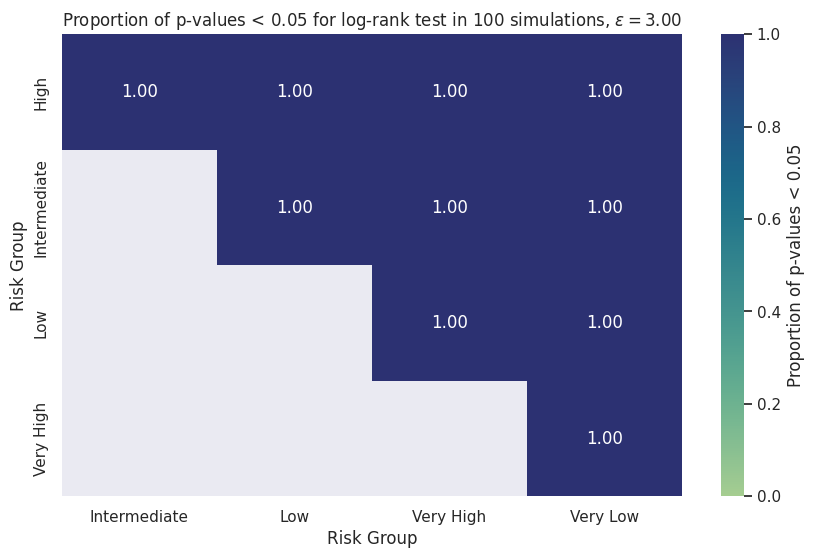

In [13]:
#plt a pivot table with the proportion of p-values < 0.05
plt.figure(figsize=(10, 6))
sns.heatmap(df_results, annot=True, cmap='crest', cbar_kws={'label': 'Proportion of p-values < 0.05'}, fmt=".2f", vmin=0, vmax=1)   
#adjust the values of the p values to be between 0 and 100
plt.xlabel('Risk Group')
plt.ylabel('Risk Group')

#format e1 to 2 decimal places
plt.title('Proportion of p-values < 0.05 for log-rank test in ' f'{times} simulations'+r', $\varepsilon = $' + f'{e:.2f}')
plt.show()


In [14]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                           test_statistic      p  -log2(p)
High         Intermediate           57.64 <0.005     44.85
             Low                   232.61 <0.005    172.05
             Very High              34.13 <0.005     27.53
             Very Low              244.19 <0.005    180.44
Intermediate Low                    42.25 <0.005     33.54
             Very High             180.06 <0.005    133.96
             Very Low               82.76 <0.005     63.23
Low          Very High             485.68 <0.005    355.13
             Very Low               20.90 <0.005     17.66
Very High    Very Low              413.68 <0.005    303.08

In [15]:
results_dp.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                           test_statistic      p  -log2(p)
High         Intermediate           52.76 <0.005     41.27
             Low                   209.75 <0.005    155.49
             Very High              23.37 <0.005     19.51
             Very Low              223.45 <0.005    165.42
Intermediate Low                    37.48 <0.005     30.01
             Very High             146.84 <0.005    109.86
             Very Low               75.04 <0.005     57.59
Low          Very High             412.10 <0.005    301.94
             Very Low               18.95 <0.005     16.18
Very High    Very Low              360.73 <0.005    264.79

# Kidney Dataset

McGilchrist et al. URL: https://www.jstor.org/stable/2532138

In [16]:
data_path = "../data/"
author = "McGilchristEtAl/"

#read the data
path = data_path+author+'kidney.csv'

df = pd.read_csv(path, sep=',')
df = df[['time', 'status', 'disease']]

#raname columns
df = df.rename(columns={'time': 'Time', 'status': 'Status', 'disease': 'Disease'})

df['Time'] = df['Time']/30

df_kidney = df.copy()

df

,Time,Status,Disease
0,0.266667,1,Other
1,0.533333,1,Other
2,0.766667,1,GN
3,0.433333,0,GN
4,0.733333,1,Other
...,...,...,...
71,0.533333,0,Other
72,0.200000,0,PKD
73,2.600000,1,PKD
74,2.100000,1,PKD


## Group Survival Analysis


### LNTO Simulation

### RRR Simulation

In [17]:
#get unique risks groups
risk_groups = df['Disease'].unique()
risk_groups

array(['Other', 'GN', 'AN', 'PKD'], dtype=object)

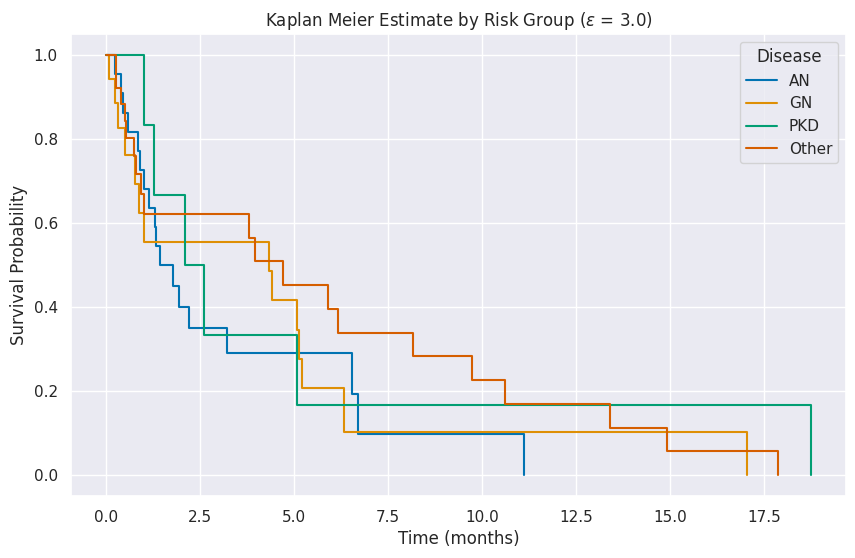

In [18]:
# set the coin bias
#e1 = 1 -> p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#e1 = 2 -> p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#e1 = 3 -> p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
n = len(risk_groups)

#p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e1 = verify_epsilon(p, n)
# privatize the IPSS-R category
df['Privatized Disease'] = df['Disease'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))

groups = df['Privatized Disease']
ix_an = (groups == 'AN')
ix_gn = (groups == 'GN')
ix_pkd = (groups == 'PKD')
ix_o = (groups == 'Other')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_an, ix_gn, ix_pkd, ix_o], ['AN', 'GN', 'PKD', 'Other']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

plt.title(r'Kaplan Meier Estimate by Risk Group ($\epsilon$ = {})'.format(round(e1, 2)))
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend(title='Disease', loc = 'best')

plt.show()

In [19]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 1.77
     AN_lower_0.95  AN_upper_0.95
0.5            0.9            3.2
Median survival time: 4.33
     GN_lower_0.95  GN_upper_0.95
0.5            0.5            5.2
Median survival time: 2.10
     PKD_lower_0.95  PKD_upper_0.95
0.5             1.0       18.733333
Median survival time: 4.70
     Other_lower_0.95  Other_upper_0.95
0.5               0.8          8.166667


In [20]:
p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e = verify_epsilon(p, n)
times = 100

# Fitting and plotting for each risk group
medians = []
medians_ci = []
dfs = []
for i in range(1, times+1):
    df['Privatized Disease'] = df['Disease'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))
    groups = df['Privatized Disease']
    ix_an = (groups == 'AN')
    ix_gn = (groups == 'GN')
    ix_pkd = (groups == 'PKD')
    ix_o = (groups == 'Other')
    
    km = KaplanMeierFitter()
    for ix, label in zip([ix_an, ix_gn, ix_pkd, ix_o], ['AN', 'GN', 'PKD', 'Other']):
        km.fit(df['Time'][ix], df['Status'][ix], label=label)
        medians.append(km.median_survival_time_)
        medians_ci.append(median_survival_times(km.confidence_interval_))
    results_dp = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Privatized Disease'], df['Status'])
    temp = pd.DataFrame(results_dp.summary)
    temp['iteration'] = i
    dfs.append(temp)


plt.show()

In [21]:
results = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Disease'], df['Status'])

In [22]:
#concatenate all df in dfs, summing the values of the test statistic and counting the proportion of p-values < 0.05 for each index
df_results = pd.concat(dfs)
df_results = df_results.reset_index()
#group by level_0 and level_1 and sum the values of the test statistic and count the proportion of p-values < 0.05
df_results = df_results.groupby(['level_0', 'level_1']).agg({'test_statistic': 'sum', 'p': lambda x: (x < 0.05).sum()/len(x)}).reset_index()

#pivot the table
df_results = df_results.pivot(index='level_0', columns='level_1', values='p')

df_results


level_1,GN,Other,PKD
level_0,,,
AN,0.0,0.00,0.0
GN,NaN,0.01,0.0
Other,NaN,NaN,0.0


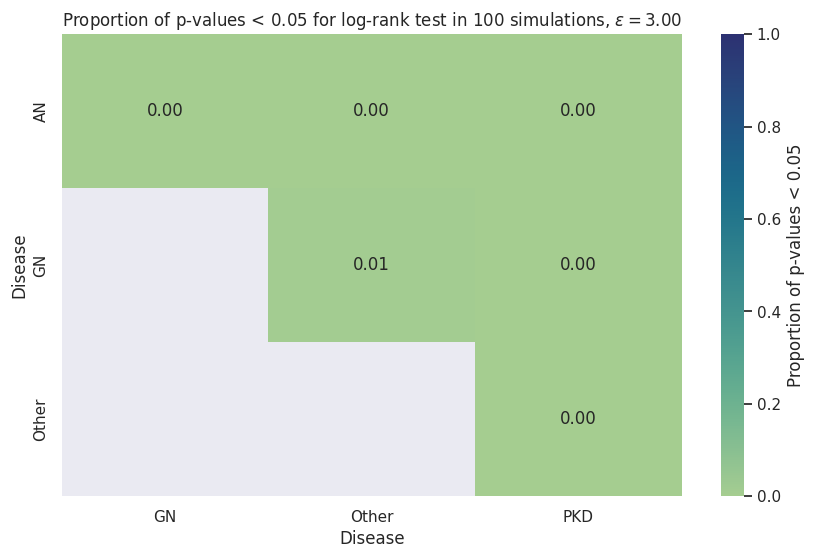

In [23]:
#plt a pivot table with the proportion of p-values < 0.05
plt.figure(figsize=(10, 6))
sns.heatmap(df_results, annot=True, cmap='crest', cbar_kws={'label': 'Proportion of p-values < 0.05'}, fmt=".2f", vmin=0, vmax=1)   
#adjust the values of the p values to be between 0 and 100
plt.xlabel('Disease')
plt.ylabel('Disease')

#format e1 to 2 decimal places
plt.title('Proportion of p-values < 0.05 for log-rank test in ' f'{times} simulations'+r', $\varepsilon = $' + f'{e:.2f}')
plt.show()


In [24]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
             test_statistic    p  -log2(p)
AN    GN               0.01 0.93      0.11
      Other            1.69 0.19      2.37
      PKD              1.09 0.30      1.75
GN    Other            0.99 0.32      1.64
      PKD              0.60 0.44      1.19
Other PKD              0.26 0.61      0.71

In [25]:
results_dp.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
             test_statistic    p  -log2(p)
AN    GN               2.44 0.12      3.08
      Other            0.61 0.44      1.20
      PKD              0.03 0.87      0.21
GN    Other            4.18 0.04      4.61
      PKD              0.43 0.51      0.97
Other PKD              0.01 0.93      0.11